# Exploration of berries prices in the spanish market

### Cleanance

In [48]:
import pyodbc
import pandas as pd
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry = "SELECT * FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('ES' as nvarchar)"
df_prices = pd.read_sql(qry, connStr)

df_prices.shape

(447, 11)

In [61]:
# Dates in campaign time format
# df_prices['Campaign_Date'] = df_prices['Year_campaign'].astype(str) + df_prices['Week_num_campaign'].astype(str)
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
# df_prices['Campaign_Date'] = df_prices['Campaign_Date'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y%W-%w"))

# Dates natural date format
blue = df_prices[(df_prices.Product=='BLUEBERRIES') & (df_prices.Year_campaign>2015) & (df_prices.Week_num_campaign<50)][['Date_ref', 'Price']]
blue.set_index('Date_ref',inplace=True)
blue.sort_index(inplace=True)
blue.index = blue.index.astype('datetime64[ns]') 
blue_weeks = blue.resample('W').mean().asfreq('W')
rows_null = blue_weeks.isnull()
idx_null = rows_null[rows_null.any(axis=1)].index
blue_full = blue_weeks.interpolate()


### Ploting

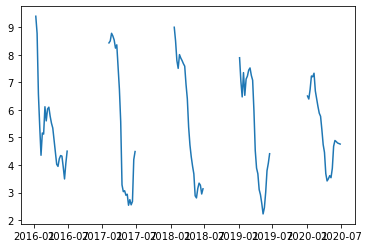

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(blue_weeks)

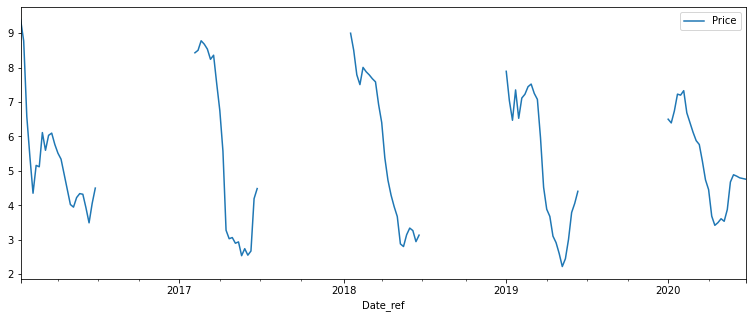

In [63]:
fig, ax = plt.subplots(figsize= (13,5))
blue_weeks.plot(ax=ax);

In [64]:
for y in range(2017,2020):
    c = blue[blue.index.year==y]['Price'].reset_index()['Price'][0:21].corr(blue[blue.index.year==y+1].reset_index()['Price'][0:21])
    print(f'Correlations between campaigns {y} and {y+1}: {c}')

Correlations between campaigns 2017 and 2018: 0.8956249612699594
Correlations between campaigns 2018 and 2019: 0.964328735988804
Correlations between campaigns 2019 and 2020: 0.9157860350396017


### ACF correlation function

In [65]:
from statsmodels.tsa.stattools import acf
acf(blue)

array([ 1.        ,  0.86104549,  0.69186141,  0.50789583,  0.31865133,
        0.14438902, -0.04818119, -0.23434428, -0.41264613, -0.56581256,
       -0.67487525, -0.73442129, -0.71906835, -0.63802788, -0.52902053,
       -0.39317501, -0.23287666, -0.05615846,  0.13414854,  0.30331095,
        0.42608891,  0.51847942,  0.56344551,  0.60853751,  0.60121845,
        0.56228992,  0.4640867 ,  0.33882347,  0.20524073,  0.05949822,
       -0.0811932 , -0.20598205, -0.32455124, -0.42532552, -0.51070107,
       -0.54084048, -0.50774011, -0.44443095, -0.36043758, -0.25592986,
       -0.15475514])

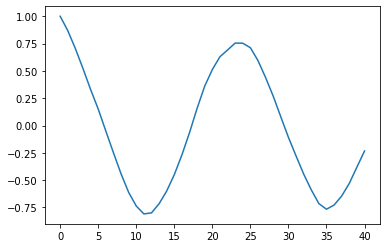

In [66]:
plt.plot(acf(blue,unbiased=True))

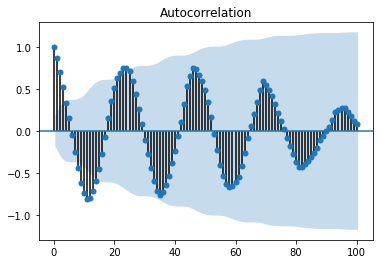

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(blue,lags=100,unbiased=True);

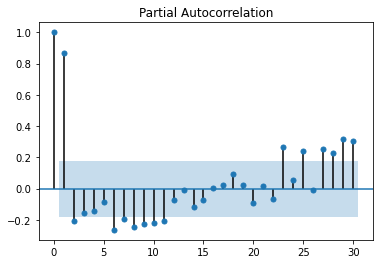

In [68]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(blue, lags = 30);

## First model!!
## https://www.youtube.com/watch?v=WjeGUs6mzXg

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(blue_full, order = (3,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  234
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -91.388
Date:                Tue, 07 Jul 2020   AIC                            194.776
Time:                        19:53:22   BIC                            215.482
Sample:                    01-10-2016   HQIC                           203.125
                         - 06-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5639      0.068     -8.311      0.000      -0.697      -0.431
ar.L2         -0.3217      0.073     -4.422      0.000      -0.464      -0.179
ar.L3          0.4244      0.048      8.769      0.000       0.330       0.519
ma.L1          1.0200      0.059     17.173      0.000       0.904       1.136
ma.L2          0.9412      0.057     16.435      0.000       0.829       1.053
sigma2         0.1276      0.006     20.896      0.000       0.116       0.140
===================================================================================
Ljung-Box (Q):                       22.76   Jarque-Bera (JB):               502.85
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.95
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

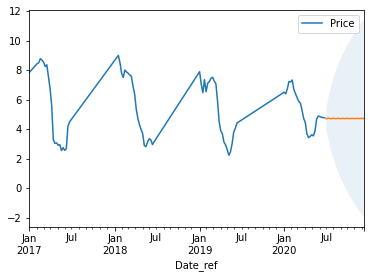

In [70]:
blue_full.truncate(before='2017').plot()
prediction = model.get_forecast(steps=24)
prediction.predicted_mean.plot()
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
plt.fill_between(lower.index,lower,upper, alpha=0.1)
plt.show()

### MSE, RMSE, MAE, MAPE

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Use against predictions

predictions_clean = model.fittedvalues[~model.fittedvalues.index.isin(idx_null)]
blue_clean = blue_full[~blue_full.index.isin(idx_null)]
# https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition?rq=1

mse = mean_squared_error(predictions_clean, blue_clean.Price)
rmse = np.sqrt(mean_squared_error(predictions_clean, blue_clean.Price))
mae = mean_absolute_error(predictions_clean, blue_clean.Price)
mape = np.mean(np.abs(predictions_clean-blue_clean.Price)/blue_clean.Price)

print(f'MSE {mse}, RMSE {rmse},*** \033[1mMAE {mae} ***\033[1m, MAPE {mape}')

MSE 0.9892219367241887, RMSE 0.9945963687467337,*** MAE 0.429270655163812 ***, MAPE 0.08169478985758574


In [73]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore')
#https://stackoverflow.com/questions/34444607/how-to-ignore-statsmodels-maximum-likelihood-convergence-warning
best_aic = 999999
for p in range(3):
    for q in range(2):
        for d in range(2):
            try:
                model = SARIMAX(blue, order = (p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    print(p, d, q, model.aic, model.bic)
            except:
                pass

0 0 0 752.8476162056207 755.6267396987323
0 1 0 318.92267472705623 321.6933593515219
0 1 1 318.76590774443855 324.3072769933699
1 1 0 318.18782953911267 323.729198788044
2 1 0 318.0584861882486 326.3705400616456


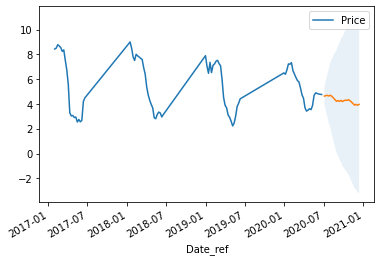

In [74]:
model = SARIMAX(blue_full, order = (2, 1, 0),seasonal_order=(1,1,2,12)).fit()
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.1)
plt.show()

In [75]:
### https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [117]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model_fit = SARIMAX(history, order=arima_order).fit()
		#model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error

	test_clean = test#[~test.index.isin(idx_null)]
	predictions_clean = predictions#[~predictions.index.isin(idx_null)]
	error = mean_absolute_error(test_clean, predictions_clean) #MAE is the metric selected as price fluctuation could be up or down
	
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mae = evaluate_arima_model(dataset, order)
					if mae < best_score:
						best_score, best_cfg = mae, order
					print('ARIMA%s MAE=%.3f' % (order,mae))
				except:
					continue
	print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [177]:
listIndex = list(zip(blue_full.index, range(0,len(blue_full))))
listNull = idx_null

dfIndex = pd.DataFrame(listIndex)
dfNull = pd.DataFrame(listNull)
dfIndex.columns = ['Date_ref','ID']
dfNullID = dfIndex.merge(dfNull, how='inner', on='Date_ref')


In [180]:
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
blue_full.index[list(dfNullID.ID)]

DatetimeIndex(['2016-07-03', '2016-07-10', '2016-07-17', '2016-07-24',
               '2016-07-31', '2016-08-07', '2016-08-14', '2016-08-21',
               '2016-08-28', '2016-09-04',
               ...
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29'],
              dtype='datetime64[ns]', name='Date_ref', length=115, freq=None)

In [181]:
train[list(dfNullID.ID)]

IndexError: index 154 is out of bounds for axis 0 with size 154

In [137]:
idxn = range(0,len(train))
train[idxn]
#range(0,len(train))

array([[9.39488958],
       [8.77146007],
       [6.57785387],
       [5.40715261],
       [4.35400539],
       [5.16097374],
       [5.12141425],
       [6.11346262],
       [5.59948281],
       [6.0334038 ],
       [6.09757619],
       [5.76882076],
       [5.51594305],
       [5.34183934],
       [4.90085434],
       [4.47250201],
       [4.02649597],
       [3.95075246],
       [4.22836173],
       [4.34298465],
       [4.32426773],
       [3.9318743 ],
       [3.49524617],
       [4.059009  ],
       [4.50325504],
       [4.62589456],
       [4.74853408],
       [4.8711736 ],
       [4.99381312],
       [5.11645264],
       [5.23909216],
       [5.36173168],
       [5.4843712 ],
       [5.60701072],
       [5.72965024],
       [5.85228976],
       [5.97492929],
       [6.09756881],
       [6.22020833],
       [6.34284785],
       [6.46548737],
       [6.58812689],
       [6.71076641],
       [6.83340593],
       [6.95604545],
       [7.07868497],
       [7.20132449],
       [7.323

In [128]:
	test_clean #= test#[~test.index.isin(idx_null)]
	#predictions_clean = predictions#[~predictions.index.isin(idx_null)]
    train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]

array([[7.55111588],
       [7.72083844],
       [7.89056099],
       [7.04054175],
       [6.4703171 ],
       [7.3506639 ],
       [6.52742437],
       [7.11569917],
       [7.22506406],
       [7.44436915],
       [7.52037743],
       [7.24952569],
       [7.07635795],
       [5.96505176],
       [4.52641995],
       [3.88939363],
       [3.68205316],
       [3.10986098],
       [2.92070071],
       [2.60615465],
       [2.22739637],
       [2.45385924],
       [3.01434076],
       [3.79402865],
       [4.06116223],
       [4.4102436 ],
       [4.48237004],
       [4.55449648],
       [4.62662291],
       [4.69874935],
       [4.77087579],
       [4.84300223],
       [4.91512867],
       [4.98725511],
       [5.05938155],
       [5.13150799],
       [5.20363443],
       [5.27576087],
       [5.34788731],
       [5.42001375],
       [5.49214019],
       [5.56426663],
       [5.63639307],
       [5.70851951],
       [5.78064595],
       [5.85277239],
       [5.92489883],
       [5.997

In [118]:
# evaluate parameters
p_values = [3]
d_values = [1]
q_values = [2]
warnings.filterwarnings("ignore")
evaluate_models(blue_full.values, p_values, d_values, q_values)

ARIMA(3, 1, 2) MAE=0.243
Best ARIMA(3, 1, 2) MAE=0.243


In [119]:
X =blue_full.values
arima_order = (3,1,2)
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
    model_fit = SARIMAX(history, order=arima_order).fit()
    #model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error

test_clean = test#[~test.index.isin(idx_null)]
predictions_clean = predictions#[~predictions.index.isin(idx_null)]
error = mean_absolute_error(test_clean, predictions_clean) #MAE is the metric selected as price fluctuation could be up or down

test



0.2435184867335513

In [207]:
# load dataset
blue = blue
# evaluate parameters
p_values = range(0, 6)
d_values = [0, 1, 2, 4]
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(blue.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1.409
ARIMA(0, 0, 1) MSE=0.827
ARIMA(0, 0, 2) MSE=0.625
ARIMA(0, 1, 0) MSE=0.389
ARIMA(0, 1, 1) MSE=0.371
ARIMA(0, 1, 2) MSE=0.351
ARIMA(0, 2, 0) MSE=0.395
ARIMA(0, 2, 1) MSE=0.439
ARIMA(0, 2, 2) MSE=0.414
ARIMA(1, 0, 0) MSE=0.413
ARIMA(1, 0, 1) MSE=0.391
ARIMA(1, 0, 2) MSE=0.369
ARIMA(1, 1, 0) MSE=0.364
ARIMA(1, 1, 1) MSE=0.347
ARIMA(1, 1, 2) MSE=0.347
ARIMA(1, 2, 0) MSE=0.410
ARIMA(1, 2, 1) MSE=0.404
ARIMA(2, 0, 0) MSE=0.380
ARIMA(2, 1, 0) MSE=0.347
ARIMA(2, 1, 1) MSE=0.346
ARIMA(2, 1, 2) MSE=0.350
ARIMA(2, 2, 0) MSE=0.393
ARIMA(2, 2, 1) MSE=0.383
ARIMA(3, 0, 0) MSE=0.352
ARIMA(3, 1, 0) MSE=0.345
ARIMA(3, 1, 1) MSE=0.320
ARIMA(3, 1, 2) MSE=0.296
ARIMA(3, 2, 0) MSE=0.404
ARIMA(3, 2, 1) MSE=0.380
ARIMA(4, 0, 0) MSE=0.348
ARIMA(4, 1, 0) MSE=0.346
ARIMA(4, 1, 1) MSE=0.348
ARIMA(4, 1, 2) MSE=0.368
ARIMA(4, 2, 0) MSE=0.404
ARIMA(4, 2, 1) MSE=0.385
ARIMA(4, 2, 2) MSE=0.380
ARIMA(5, 0, 0) MSE=0.346
ARIMA(5, 1, 0) MSE=0.343
ARIMA(5, 1, 1) MSE=0.343
ARIMA(5, 1, 2) MSE=0.322


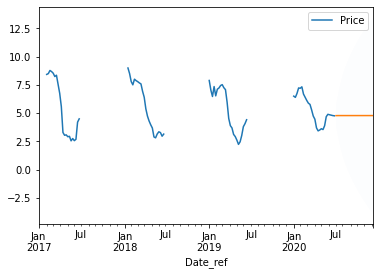

In [208]:
model = SARIMAX(blue_full, order = (3, 1, 2)).fit() #,seasonal_order=(1,1,2,12)
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue_full.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.01)
plt.show()

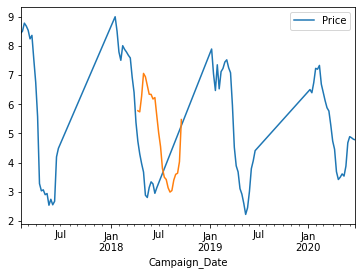

In [70]:
model = SARIMAX(blue, order = (5, 2, 2),seasonal_order=(1,1,2,24)).fit()
prediction = model.get_forecast(steps = 24)
#lower = prediction.conf_int()['lower Price']
#upper = prediction.conf_int()['upper Price']
blue.truncate(before='2017').plot()
prediction.predicted_mean.plot()
#plt.fill_between(lower.index,lower,upper, alpha=0.4)
plt.show()

In [71]:
prediction.predicted_mean.index

PeriodIndex(['2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24', '2018-06-25/2018-07-01',
             '2018-07-02/2018-07-08', '2018-07-09/2018-07-15',
             '2018-07-16/2018-07-22', '2018-07-23/2018-07-29',
             '2018-07-30/2018-08-05', '2018-08-06/2018-08-12',
             '2018-08-13/2018-08-19', '2018-08-20/2018-08-26',
             '2018-08-27/2018-09-02', '2018-09-03/2018-09-09',
             '2018-09-10/2018-09-16', '2018-09-17/2018-09-23'],
            dtype='period[W-SUN]', freq='W-SUN')

In [72]:
blue[blue.index.year==2018].index

PeriodIndex(['2018-01-15/2018-01-21', '2018-01-22/2018-01-28',
             '2018-01-29/2018-02-04', '2018-02-05/2018-02-11',
             '2018-02-12/2018-02-18', '2018-02-19/2018-02-25',
             '2018-02-26/2018-03-04', '2018-03-05/2018-03-11',
             '2018-03-12/2018-03-18', '2018-03-19/2018-03-25',
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24'],
            dtype='period[W-SUN]', name='Campaign_Date', freq='W-SUN')

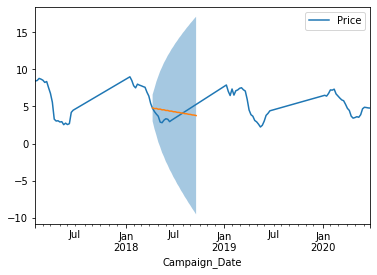

In [74]:
model = SARIMAX(blue, order = (5, 2, 2)).fit()
prediction = model.get_forecast(steps = 24)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
fig, ax = plt.subplots()
blue.truncate(before = "2017").plot(ax = ax)
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

In [75]:
prediction.predicted_mean.index

PeriodIndex(['2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03',
             '2018-06-04/2018-06-10', '2018-06-11/2018-06-17',
             '2018-06-18/2018-06-24', '2018-06-25/2018-07-01',
             '2018-07-02/2018-07-08', '2018-07-09/2018-07-15',
             '2018-07-16/2018-07-22', '2018-07-23/2018-07-29',
             '2018-07-30/2018-08-05', '2018-08-06/2018-08-12',
             '2018-08-13/2018-08-19', '2018-08-20/2018-08-26',
             '2018-08-27/2018-09-02', '2018-09-03/2018-09-09',
             '2018-09-10/2018-09-16', '2018-09-17/2018-09-23'],
            dtype='period[W-SUN]', freq='W-SUN')